## Pre-Processing and Modeling

### Introduction

Having wrangled and explored the data, we can now begin to prepare the data for modeling. I will use an ARIMA model to forecast weekly deaths in 2020-21. After doing so, we can compare the forecast to actual and estimate excess deaths as the variance. First, we need to check if our time series data is stationary. If it's not, then we will need to transform it to be stationary. Non-stationary time series show the effect of seasonality, trends, or other measures dependent on the time index. This will make forecasting, with considerations to the mean and variance, rather difficult. 

There will be other time series forecast models to consider as well. In fact, we can break apart the ARIMA model into sub-models depending on the nature of our time series. An ARIMA model is a combonation of the following components:

- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

The parameters of the ARIMA model are defined as follows:

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

Any of these parameters can be set to 0, effectively allowing for the ARIMA model to be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

### Imports and Data Load

The last notebook finished with an export of clean data after exploring, formatting, and arranging it for our project needs. Let's jump back in with importing packages and the two datasets: deaths and temps. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [2]:
deaths = pd.read_csv('deaths_cleaned.csv')
temps = pd.read_csv('temps_cleaned.csv')

In [3]:
#Checking the contents and Dtype of deaths data
deaths.head()

,Week of Date,Week start,Week end,2020-21 deaths,Average 2017-2019,Excess deaths (over 3-yr average),Average 2015-2019,Excess deaths (over 5-yr average),COVID-19 deaths,Non-Covid deaths per Week
0,Week starting 1/05/2020,2020-01-05,2020-01-11,764,845,-81,796,-32,0,764
1,Week starting 1/12/2020,2020-01-12,2020-01-18,776,800,-24,765,11,0,776
2,Week starting 1/19/2020,2020-01-19,2020-01-25,751,781,-30,760,-9,0,751
3,Week starting 1/26/2020,2020-01-26,2020-02-01,719,724,-5,724,-5,0,719
4,Week starting 2/02/2020,2020-02-02,2020-02-08,733,756,-23,757,-24,0,733


In [4]:
deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Week of Date                       95 non-null     object
 1   Week start                         95 non-null     object
 2   Week end                           95 non-null     object
 3   2020-21 deaths                     95 non-null     int64 
 4   Average 2017-2019                  95 non-null     int64 
 5   Excess deaths (over 3-yr average)  95 non-null     int64 
 6   Average 2015-2019                  95 non-null     int64 
 7   Excess deaths (over 5-yr average)  95 non-null     int64 
 8   COVID-19 deaths                    95 non-null     int64 
 9   Non-Covid deaths per Week          95 non-null     int64 
dtypes: int64(7), object(3)
memory usage: 7.5+ KB


The 'Week start' and 'Week end' dates returned to objects. I'll need to convert them to datetime so we can plot.

In [5]:
deaths['Week start'] = pd.to_datetime(deaths['Week start'])
deaths['Week end'] = pd.to_datetime(deaths['Week end'])
deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Week of Date                       95 non-null     object        
 1   Week start                         95 non-null     datetime64[ns]
 2   Week end                           95 non-null     datetime64[ns]
 3   2020-21 deaths                     95 non-null     int64         
 4   Average 2017-2019                  95 non-null     int64         
 5   Excess deaths (over 3-yr average)  95 non-null     int64         
 6   Average 2015-2019                  95 non-null     int64         
 7   Excess deaths (over 5-yr average)  95 non-null     int64         
 8   COVID-19 deaths                    95 non-null     int64         
 9   Non-Covid deaths per Week          95 non-null     int64         
dtypes: datetime64[ns](2), int64(7), object(1

In [6]:
#Checking the contents and Dtype of deaths data
temps.head()

,DATE,TMAX,TMIN
0,2020-01-01,54.0,46.0
1,2020-01-02,54.0,42.0
2,2020-01-03,61.0,42.0
3,2020-01-04,53.0,41.0
4,2020-01-05,47.0,41.0


In [7]:
temps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12324 entries, 0 to 12323
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    670 non-null    object 
 1   TMAX    670 non-null    float64
 2   TMIN    670 non-null    float64
dtypes: float64(2), object(1)
memory usage: 289.0+ KB


Both data sets are as expected from our previous efforts. One of the first things we need to determine is if our time series is stationary. Often times you can determine this by simply looking at the plot. Think average daily temperature in the U.S. over a year. There will be clear seasonality making the time series non-stationary. If you consider world population over time, you'll have an example of a time series that isn't stationary due to trending.

In [8]:
#Identifying the heatwave dates for reference and visualization
high_temp = 103
high_temp_days = temps.loc[temps['TMAX'] > high_temp, 'DATE'].tolist()
high_temp_days

['2021-06-26', '2021-06-27', '2021-06-28']

Let's check our plot again and see how it's looking. 

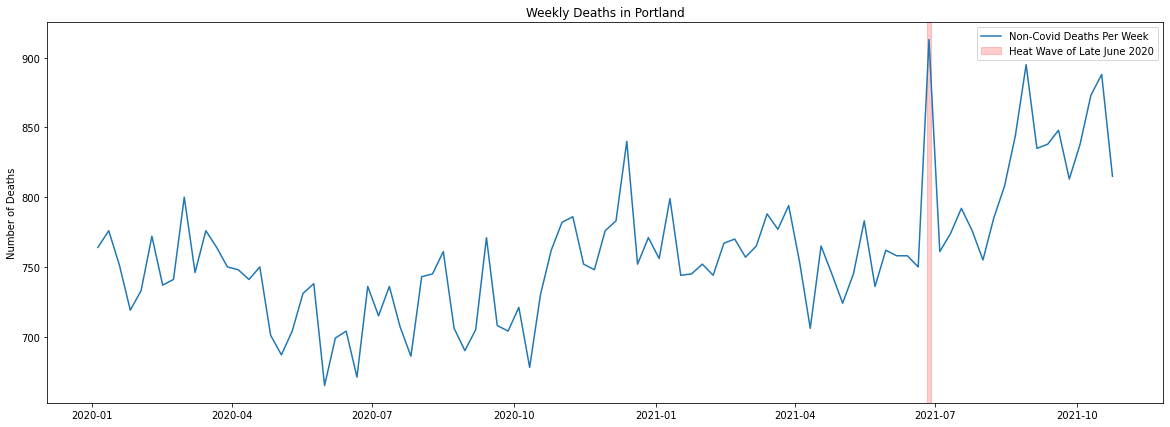

In [9]:
#Plotting the non-covid deaths with reference to the heat wave
_ = plt.figure(figsize = (20, 7))
_ = plt.plot(deaths['Week start'], deaths['Non-Covid deaths per Week'], label = 'Non-Covid Deaths Per Week')
_ = plt.axvspan(min(high_temp_days), max(high_temp_days), alpha = 0.2, color = 'red', label = 'Heat Wave of Late June 2020')
_ = plt.ylabel('Number of Deaths')
_ = plt.title('Weekly Deaths in Portland')
_ = plt.legend()

### Evaluate for Stationary Time Series

It's hard to say for certain if this data is stationary or not. There appears to be an inconsisent mean and variance but is it significant enough to call this non-stationary? We need to explore further in order to determine this.

One method to determine if a time series is stationary is to plot the rolling mean and standard deviation for deaths per week. I'll be looking for flat lines, parallel to the x-axis. I'm going to use non-covid deaths only moving forward.

In [10]:
df = deaths[['Week start', 'Non-Covid deaths per Week']]
df.rename(columns={'Week start': 'date', 'Non-Covid deaths per Week': 'deaths'}, inplace=True)

In [11]:
df.head()

,date,deaths
0,2020-01-05,764
1,2020-01-12,776
2,2020-01-19,751
3,2020-01-26,719
4,2020-02-02,733


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    95 non-null     datetime64[ns]
 1   deaths  95 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [13]:
#Defining our rolling stats
rolling_mean = df['deaths'].rolling(window = 8).mean()
rolling_std = df['deaths'].rolling(window = 8).std()

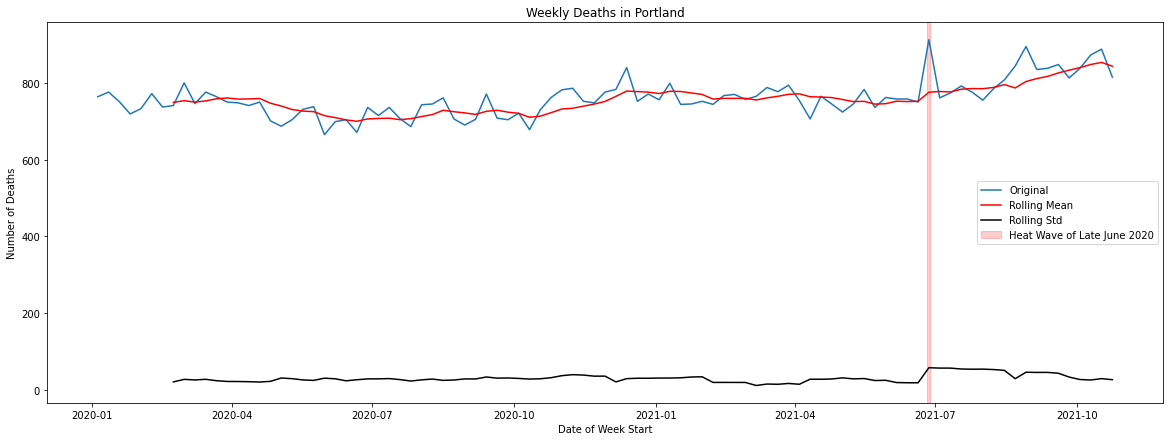

In [14]:
#Plotting the deaths with reference to the rolling stats
_ = plt.figure(figsize = (20, 7))
_ = plt.plot(df['date'], df['deaths'], label = 'Original')
_ = plt.plot(df['date'], rolling_mean, color = 'red', label = 'Rolling Mean')
_ = plt.plot(df['date'], rolling_std, color = 'black', label = 'Rolling Std')
_ = plt.axvspan(min(high_temp_days), max(high_temp_days), alpha = 0.2, color = 'red', label = 'Heat Wave of Late June 2020')
_ = plt.xlabel('Date of Week Start')
_ = plt.ylabel('Number of Deaths')
_ = plt.title('Weekly Deaths in Portland')
_ = plt.legend()

It's too unclear to say from our plot. The window for rolling stats is 8 weeks. The standard deviation is mostly flat but with some jumps, and the mean trends up after the heat wave. Another method to determine stationaries is the Augmented Dickey-Fuller Test: The time series is considered stationary if the p-value is low (according to the null hypothesis) and the critical values at 1%, 5%, 10% confidence intervals are as close as possible to the ADF Statistics.

In [15]:
result = adfuller(df['deaths'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.784015129639363
p-value: 0.3884261171096379
Critical Values:
	1%: -3.503514579651927
	5%: -2.893507960466837
	10%: -2.583823615311909


The results of the ADF Test, combined with the ambiguity of our plot, suggests that the time series is NOT stationary. Not surprising when you consider the deaths data includes the large spike from heat and indirect COVID deaths in late 2021. I'm going to go ahead and split the data for modeling. We can then check to see if our train data is stationary. 

Train data will be all dates leading up to, but not including, the heat wave (and subsequent increase in average deaths) while the test data will be from the heat wave on. One benefit of doing this is that the ARIMA object's forecast() function will forecast the first step outside of training data. This will be the week of record heat.

In [16]:
#We know the dates of the heat wave from above
train = df.loc[df['date'] <= '2021-06-25']
test = df.loc[df['date'] > '2021-06-25']

I found a function online (sourced below) that can help us check for stationarity more easily. 

In [17]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=8).mean()
    rolling_std = timeseries.rolling(window=8).std()
    
    # rolling statistics plot
    plt.figure(figsize = (20, 6))
    original = plt.plot(timeseries['date'], timeseries['deaths'], color='blue', label='Original')
    mean = plt.plot(timeseries['date'], rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(timeseries['date'], rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['deaths'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
        
#Sourced by https://towardsdatascience.com/
#machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

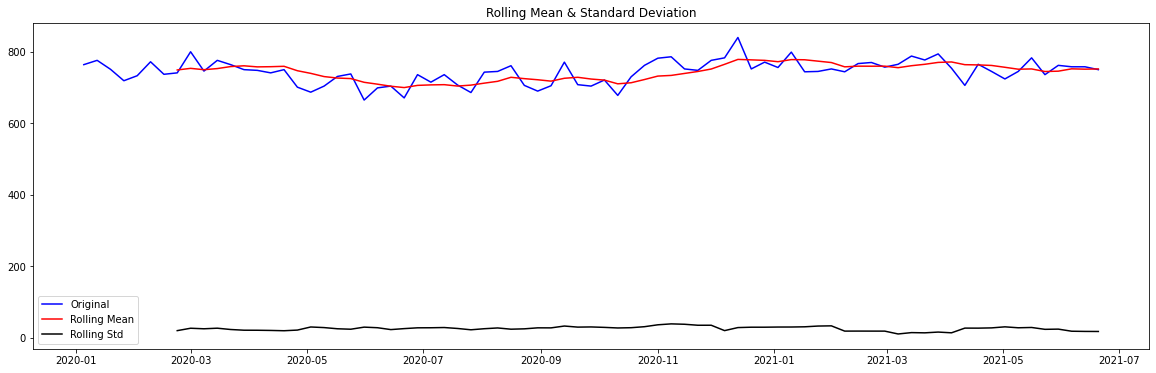

ADF Statistic: -5.1311745481224635
p-value: 1.213054013167029e-05
Critical Values:
	1%: -3.5194805351545413
	5%: -2.9003945086747343
	10%: -2.5874984279778395


In [18]:
get_stationarity(train)

The train data appears to be stationary. This will allow us to build a model with some or all of the component models that make up an ARIMA model using the train data set. From there, we can evaluate the performance with our test data and forecast against our heat wave data. First, we need to determine the parameters for the model: p, q, and d.

### Modeling

The first thing we need to do for our ARIMA model is to determine the model parameter values.

Here are the parameters we need to define:

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of difference.
- q: The size of the moving average window, also called the order of moving average.

We can look at plots for the autocorrelation function (ACF) and partial autocorrelation function (PACF) to determine the parameters p and q. I'll set the value of d to 0 since we did not have to difference our raw observations. Differencing is done to transform data to stationary if needed. 

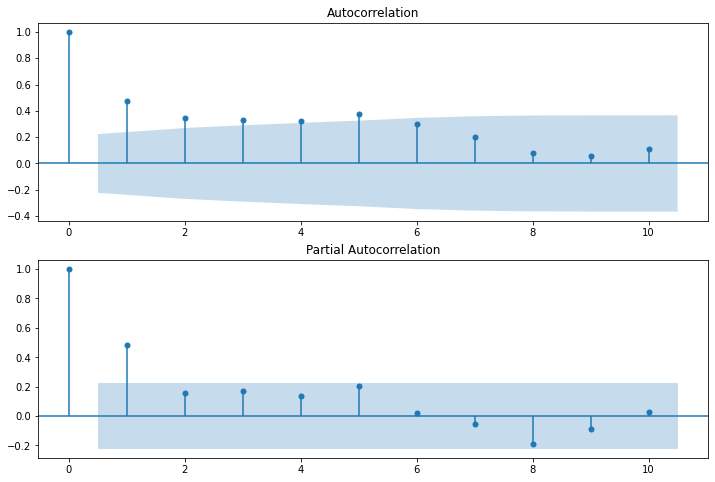

In [19]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train['deaths'], lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train['deaths'], lags=10, ax=ax2)

The shaded blue horizontals represent the significance thresholds. The vertical lines represent the ACF and PACF values at a point in time. Only the vertical lines that exceed the horizontal lines are considered significant.

The ACF can be used to figure out the best order of the MA model. Counting only the values that exceed the significance thresholds, I'll use only use the preceeding 6 weeks.

We can use PACF to figure out the best order of the AR model. The lag count determines the order of the model. With the first 2 values above threshold, I’ll use the preceding 2 weeks in the autoregression equation. I will proceed with defining our model instance with the ARIMA parameter values (p=2, d=0, q=6).

In [20]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(train['deaths'],order=(2,0,6))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 deaths   No. Observations:                   77
Model:                     ARMA(2, 6)   Log Likelihood                -362.284
Method:                       css-mle   S.D. of innovations             26.505
Date:                Wed, 17 Nov 2021   AIC                            744.569
Time:                        14:47:03   BIC                            768.007
Sample:                             0   HQIC                           753.944
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          744.8757      6.853    108.688      0.000     731.443     758.308
ar.L1.deaths     0.7918      0.321      2.467      0.014       0.163       1.421
ar.L2.deaths    -0.5413      0.281     -1.928      0.054      -1.092       0.009
ma.L1.deaths    -0.5007      0.332     -1.506      0.132      -1.152       0.151
ma.L2.deaths     0.4822      0.246      1.959      0.050      -0.000       0.964
ma.L3.deaths     0.2706      0.145      1.865      0.062      -0.014       0.555
ma.L4.deaths     0.1290      0.159      0.811      0.417      -0.183       0.441
ma.L5.deaths     0.2382      0.141      1.689      0.091      -0.038       0.515
ma.L6.deaths     0.1169      0.152      0.767      0.443      -0.182       0.416
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.7314           -1.1456j            1.3592           -0.1596
AR.2            0.7314           +1.1456j            1.3592            0.1596
MA.1            0.7516           -0.7521j            1.0633           -0.1250
MA.2            0.7516           +0.7521j            1.0633            0.1250
MA.3            0.0831           -1.3662j            1.3687           -0.2403
MA.4            0.0831           +1.3662j            1.3687            0.2403
MA.5           -1.8539           -0.7767j            2.0101           -0.4369
MA.6           -1.8539           +0.7767j            2.0101            0.4369
-----------------------------------------------------------------------------
"""

We get a nice summary from our model results. The key areas to focus on are the coefficients and p-values. If the p-value is less than or equal to the significance level (0.05 by default), we can conclude that the coefficient is statistically significant. If the p-value is greater than the significance level, we cannot conclude that the coefficient is statistically significant. I may want to refit the model without the term.

Note: I attempted to refit the model without the statistically insignificant coefficents and found no meaningful improvements to the model.

### Model Performance

The ARIMA object provides a predict() function for making forecasts. The predict function can be used to predict arbitrary in-sample and out-of-sample time steps, including the next out-of-sample forecast time step.

The predict function requires a start and an end to be specified, these can be the indexes of the time steps relative to the beginning of the training data used to fit the model.

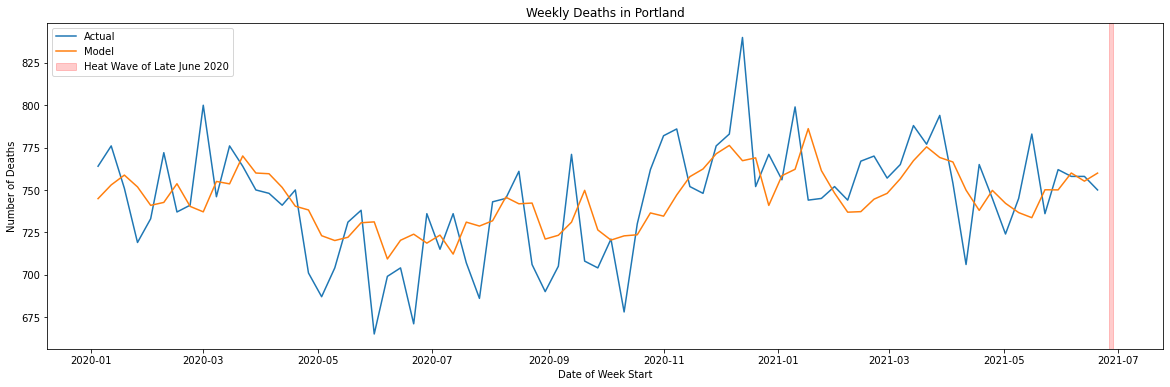

In [21]:
#Plotting actual deaths with predicted deaths from model
_ = plt.figure(figsize = (20, 6))
_ = plt.plot(train['date'], train['deaths'], label = 'Actual')
_ = plt.plot(train['date'], model_fit.predict(), label='Model')
_ = plt.axvspan(min(high_temp_days), max(high_temp_days), alpha = 0.2, color = 'red', label = 'Heat Wave of Late June 2020')
_ = plt.xlabel('Date of Week Start')
_ = plt.ylabel('Number of Deaths')
_ = plt.title('Weekly Deaths in Portland')
_ = plt.legend()

The model prediction looks pretty good! The most obvious errors are around May 1 and during what appears to be COVID related excess deaths during the Thanksgiving and Christmas holidays.

The predict() function can also be used to predict values beyond our train data. We also have a forecast() function to forecast a single step beyond the training data. This function has an argument called steps that allows you to specify the number of time steps to forecast. Let's plot both against the actuals for our test data.

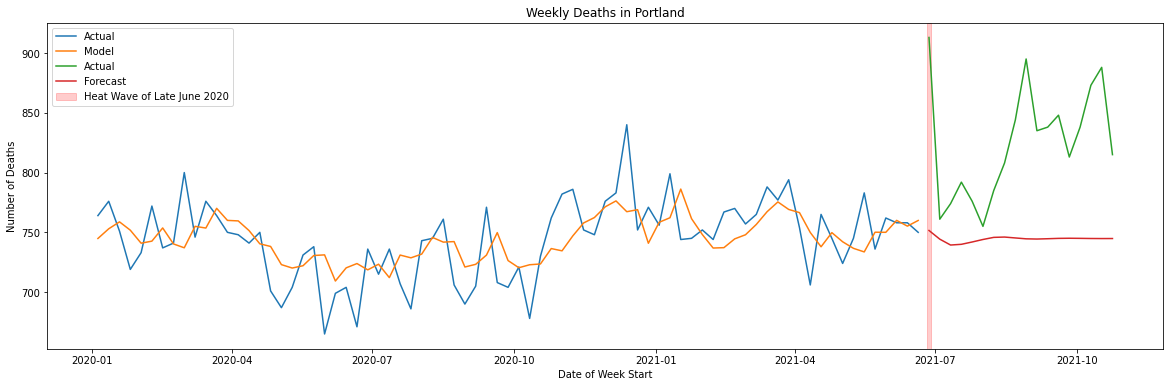

In [22]:
_ = plt.figure(figsize = (20, 6))
_ = plt.plot(train['date'], train['deaths'], label = 'Actual')
_ = plt.plot(train['date'], model_fit.predict(), label='Model')
_ = plt.plot(test['date'], test['deaths'], label = 'Actual')
_ = plt.plot(test['date'], model_fit.forecast(steps=18)[0], label='Forecast')
_ = plt.axvspan(min(high_temp_days), max(high_temp_days), alpha = 0.2, color = 'red', label = 'Heat Wave of Late June 2020')
_ = plt.xlabel('Date of Week Start')
_ = plt.ylabel('Number of Deaths')
_ = plt.title('Weekly Deaths in Portland')
_ = plt.legend()

The forecast appears to decay quickly beyond the train data. Previous noise is no longer evident and we appear to be working with a flat forecast. Let's take a closer look at just the test plot and see if there's a difference between the predict() and forecast() functions.

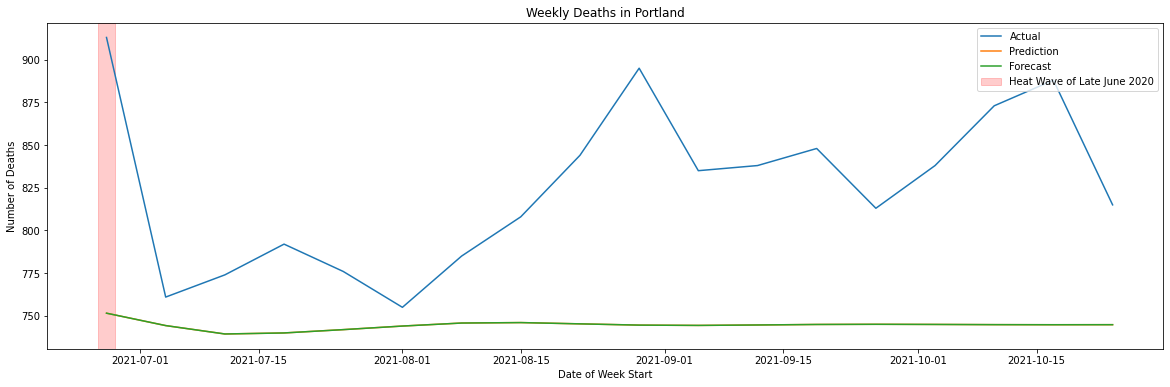

In [23]:
predict = model_fit.predict(start=77, end=94)
forecast = model_fit.forecast(steps=18)[0]

_ = plt.figure(figsize = (20, 6))
_ = plt.plot(test['date'], test['deaths'], label = 'Actual')
_ = plt.plot(test['date'], predict, label='Prediction')
_ = plt.plot(test['date'], forecast, label='Forecast')
_ = plt.axvspan(min(high_temp_days), max(high_temp_days), alpha = 0.2, color = 'red', label = 'Heat Wave of Late June 2020')
_ = plt.xlabel('Date of Week Start')
_ = plt.ylabel('Number of Deaths')
_ = plt.title('Weekly Deaths in Portland')
_ = plt.legend()

As expected, the two functions are identical. The default use for the forecast function is to predict the first out-of-sample value. Let's do that.

Now we can use the ARIMA model's forecast() function to forecast a single step beyond the training data. Recall that our training data runs right up until the week of the heat wave, so we'll be able to compare this forecast value to the actual value for our estimate of excess deaths. 

In [24]:
forecast = model_fit.forecast()
print('Forecast Deaths: {}'.format(forecast[0])) 
print('Standard Error: {}'.format(forecast[1]))
print('95% Confidence Interval: {}'.format(forecast[2]))

Forecast Deaths: [751.56721667]
Standard Error: [26.5052884]
95% Confidence Interval: [[699.617806   803.51662733]]


In [25]:
#Let's call the actual count of deaths during the heat wave (week of June 27) 
actual_deaths = test[test['date'] == '2021-06-27']
actual_deaths

,date,deaths
77,2021-06-27,913


In [26]:
#Calculating the difference in forecast and actual deaths during the heat wave
excess_deaths = 913 - forecast[0]  
print(f'Excess Deaths Due to Heat: {excess_deaths}')

Excess Deaths Due to Heat: [161.43278333]


Using the ARIMA model from above, I estimate 161 excess deaths during the week of June 27, 2021. The range of excess deaths based on the 95% confidence interval is 109 to 213 deaths. A final interesting plot to view includes the 95% confidence interval.

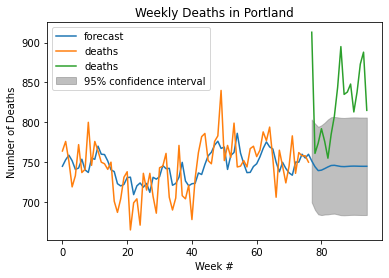

In [27]:
_ = model_fit.plot_predict(0, 94, plot_insample=True)
_ = plt.plot(test['deaths'], label='deaths')
_ = plt.xlabel('Week #')
_ = plt.ylabel('Number of Deaths')
_ = plt.title('Weekly Deaths in Portland')
_ = plt.legend()

We can see the same information as previous plots. In addition, we have a shaded region around the future forecast. This region represents the 95% confidence interval for our forecast. While the forecast itself nears static, we can see the full interval captures most of the historical death values and provides a reasonable estimate for deaths. I believe this also provides further evidence of COVID related deaths that have not been classified as COVID deaths. We can see the excess deaths at the end of 2020, where we know COVID deaths were high in Oregon, and again after the heat wave. It just so happens that late August to early October, 2021 had the highest number of COVID deaths according the the Oregon Heatlh Authority. Recall the death data here is non-COVID deaths only.

### Summary

According to the AP News, "Oregon blamed 116 deaths on the heat... More people died from the heat in the greater Portland area this June than in the entire state over the past 20 years, authorities said Tuesday."* My excess death estimate is 161 compared to Oregon's estimate of 116. If we assume the model was good, I believe the significant variance can be explained. 

I went back to the original death data sourced by OHA in the first notebook of this project. The data includes a reference to excess deaths over 3 and 5 year averages for death rates. After removing the recorded COVID deaths, I calculated non-COVID excess deaths and noticed a trend. The beginning of 2020 starts with a below average trend that slowly picks up starting in March/April of 2020, when COVID started spreading. It remains higher than average, going from single digit percentage points to sometimes more than 20% above average starting at the end of June, 2021. 

This implies a recent excess death count above what is considered a COVID death. I believe the forecast is not predicting this excess as it was not seen in the training data. The forecast plus actual heat related deaths are less than actual because the actual includes excess deaths beyond COVID and heat. I believe these deaths are COVID related as they coincide with COVID deaths.


*https://apnews.com/article/canada-environment-and-nature-oregon-heat-waves-76bb82bebd17c6bef7fd8af97c311984